# Project Introduction

Through this dataset, I have identified the three following patterns:
1. IDEA 1 w/ LOCAL LINK
2. IDEA 2 w/ LOCAL LINK
3. IDEA 3 w/ LOCAL LINK

## Resources:

- __[Kaggle-Full](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/data)__

- __[Kaggle-Sampled](https://drive.google.com/file/d/1U3u8QYzLjnEaSurtZfSAS_oh9AT2Mn8X/edit)__

- __['A Countrywide Traffic Accident Dataset'](https://arxiv.org/pdf/1906.05409)__

- __['Accident Risk Prediction based on Heterogenous Sparse Data: New Dataset & Insights](https://arxiv.org/pdf/1909.09638)__

# 1-Setup Environment

## Libraries

In [1]:
#Utilities
import warnings

# Data Basics
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

#Visuals
import matplotlib.pyplot as plt
import seaborn as sns


# Statistical Analysis
from scipy.stats import zscore

# Spatial Tools
import geopy.distance

# Text Tools
import re
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams

## Info on New Libraries
For improved analysis, these libraries were included, but not covered in the material:

-
-

## Settings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
_LITE_SWITCH_ = True

## Custom Functions

In [3]:
# For High-level data exploration
def count_outliers(df_col,cap=3):
    zs = zscore(df_col)
    return df_col[zs > cap].shape[0]

In [4]:
# For Identify Unusual Weather Pattern(s)
def unusual_weather(observation):
    flag = False
    return flag

In [5]:
def dist(pt_0,pt_1):
    return geopy.distance.geodesic(pt_0,pt_1)

In [6]:
# For indicating whether two events are close in space and, optionally, time.
def proximity_indicator(eventA,eventB,space_band=15,time_band=0):
    flag = False
    distance = dist(eventA[['longitude','latitude']],eventB[['longitude','latitude']])
    if (time_band > 0):
        time_lapse = abs(eventA['time']-eventB['time'])
        flag = bool((space_band > distance) and (time_band > time_lapse))
    else:
        flag = bool(space_band > distance)
    return flag

## Load Dataset

In [7]:
if _LITE_SWITCH_:
    data = pd.read_csv('US_Accidents_March23_sampled_500k.csv')
else:
    data = pd.read_csv('US_Accidents_March23.csv')

# 2-Initial EDA

## Schema

In [8]:
if _LITE_SWITCH_:
    data.info()
else:
    pass

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                279623 non-null  float64
 8   End_Lng                279623 non-null  float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            499999 non-null  object 
 11  Street                 499309 non-null  object 
 12  City                   499981 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu

Very large dataset with over 7.7 million observations.  That is going to be an issue to consider.  (There is a smaller dataset available on Kaggle, https://drive.google.com/file/d/1U3u8QYzLjnEaSurtZfSAS_oh9AT2Mn8X/edit).

Dimensionally much more managable with just 45 features.

In [9]:
data.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641,-91.153,NaN,NaN,0.000,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Highway 19,Zachary,East Baton Rouge,LA,70791-4610,US,US/Central,KBTR,2019-06-12 09:53:00,77.000,77.000,62.000,29.920,10.000,NW,5.000,0.000,Fair,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.991,-77.399,38.990,-77.398,0.056,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Forest Ridge Dr,Sterling,Loudoun,VA,20164-2813,US,US/Eastern,KIAD,2022-12-03 23:52:00,45.000,43.000,48.000,29.910,10.000,W,5.000,0.000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661,-120.493,34.661,-120.492,0.022,Accident on W Central Ave from Floradale Ave t...,Floradale Ave,Lompoc,Santa Barbara,CA,93436,US,US/Pacific,KLPC,2022-08-20 12:56:00,68.000,68.000,73.000,29.790,10.000,W,13.000,0.000,Fair,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.681,-92.993,43.681,-92.972,1.054,Incident on I-90 EB near REST AREA Drive with ...,14th St NW,Austin,Mower,MN,55912,US,US/Central,KAUM,2022-02-21 17:35:00,27.000,15.000,86.000,28.490,10.000,ENE,15.000,0.000,Wintry Mix,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395,-118.985,35.395,-118.986,0.046,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,River Blvd,Bakersfield,Kern,CA,93305-2649,US,US/Pacific,KBFL,2020-12-04 01:54:00,42.000,42.000,34.000,29.770,10.000,CALM,0.000,0.000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night


Notes on Features:
- 'Severity' would appear to be the primary variable of interest; 'Description' might be interesting to experiment with.  
- 'Description' feature might be an interesting avenue to explore.  
- A number of location features
    * 'Start_Lat'/'Start_Lng' are easy enough to interpret but not sure what is meant by 'End_Lat' and 'End_Lng'
    * Similar question for 'Distance(mi)'
    * Street and City might not be useful features since they are not informative without further context.  
- Identifiers in ID and Source
- We have three time features ('Weather_Timestamp', 'Start_Time' and 'End_Time').
    * They need to be [converted to datetimes](#datetimes).  Right now they are just strings.
    * There may be an issue with inconsistent formatting.
    * It may be interesting to use these values to engineer some features like time of day, season, weekday/weekend, etc.
    * However, the information contained in 'Weather_Timestamp' is unclear.
- There are 9 (not including 'Weather_Timestamp') features on the weather.
    * Visability is probably the most relevant of these but 'Weather_Condition' might be a fine substitute/summary.
- Next are 10 binary features which seem to provide some information about the road infrastructure at the location of the accident.  


In [ ]:
_TARGET_ = ['Severity']
_NUMERICS_ = ['Distance(mi)','Temperature(F)',
              'Wind_Chill(F)','Humidity(%)','Pressure(in)',
              'Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']

## Missing Values

In [14]:
data.isna().sum().sort_values(ascending=False)

End_Lat                  3402762
End_Lng                  3402762
Precipitation(in)        2203586
Wind_Chill(F)            1999019
Wind_Speed(mph)           571233
Visibility(mi)            177098
Wind_Direction            175206
Humidity(%)               174144
Weather_Condition         173459
Temperature(F)            163853
Pressure(in)              140679
Weather_Timestamp         120228
Nautical_Twilight          23246
Civil_Twilight             23246
Sunrise_Sunset             23246
Astronomical_Twilight      23246
Airport_Code               22635
Street                     10869
Timezone                    7808
Zipcode                     1915
City                         253
Description                    5
Traffic_Signal                 0
Roundabout                     0
Station                        0
Stop                           0
Traffic_Calming                0
Country                        0
Turning_Loop                   0
No_Exit                        0
End_Time  

There is a lot of missing data. 

- Most notably, the 'End_Lat'/'End_Lng'.  Will have to confirm but it would appear that observations missing one are also missing the other.  
- There aren't any missing values for 'Severity' as well as basic location data (gps + state/county).
- Only five observations are missing 'Description' which may prove convenient.


## Duplicates

There are no duplicates to deal with:

In [12]:
data.duplicated().sum()

0

## Outliers

In [16]:
if _LITE_SWITCH_:
    print(pd.DataFrame({c:{z:count_outliers(data[c],z) for z in [3,5,10,15,20]} for c in _NUMERICS_}).T)

                      3     5    10   15   20
Severity           13064     0    0    0    0
Distance(mi)        7079  2660  632  248  114
Temperature(F)         0     0    0    0    0
Wind_Chill(F)          0     0    0    0    0
Humidity(%)            0     0    0    0    0
Pressure(in)           0     0    0    0    0
Visibility(mi)         0     0    0    0    0
Wind_Speed(mph)        0     0    0    0    0
Precipitation(in)      0     0    0    0    0


Dealing with 'Distance' outliers requires additional research about the feature itself.

## Severity

In [17]:
data['Severity'].value_counts()

Severity
2    398142
3     84520
4     13064
1      4274
Name: count, dtype: int64

# 3-Data Processing

In [20]:
data_clean = pd.DataFrame()

In [76]:
data_clean[_NUMERICS_] = data[_NUMERICS_]

<a id='datetimes'> Converting dates </a>

In [ ]:
if _LITE_SWITCH_:
    data_clean['Start'] = pd.to_datetime(data['Start_Time'],format='mixed')
    data_clean['End'] = pd.to_datetime(data['End_Time'],format='mixed')
else:
    pass

## Engineer Features

In [73]:
timedelta_hrs = round((data_clean['End'] - data_clean['Start']).dt.seconds / 360)

<Axes: ylabel='Count'>

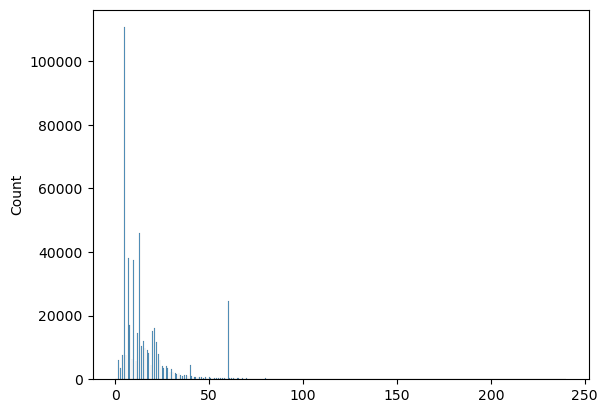

In [ ]:
sns.histplot(timedelta_hrs);

### Partition the time data

In [41]:
if _LITE_SWITCH_:
    data_clean['Month'] = data_clean['Start'].dt.month
    data_clean['Year'] = data_clean['Start'].dt.year
    data_clean['Day'] = data_clean['Start'].dt.day
    data_clean['DayofWeek'] = data_clean['Start'].dt.day_of_week
    data_clean['Quarter'] = data_clean['Start'].dt.quarter
    data_clean['Hour'] = data_clean['Start'].dt.hour
else:
    pass

In [40]:
data_clean['Year'].value_counts(normalize=True).sort_index()

Year
2016   0.053
2017   0.093
2018   0.115
2019   0.124
2020   0.152
2021   0.203
2022   0.227
2023   0.032
Name: proportion, dtype: float64

In [39]:
data_clean['Month'].value_counts(normalize=True).sort_index()

Month
1    0.097
2    0.086
3    0.071
4    0.077
5    0.072
6    0.073
7    0.067
8    0.077
9    0.085
10   0.088
11   0.098
12   0.109
Name: proportion, dtype: float64

In [ ]:
data_clean['Quarter'].value_counts(normalize=True)

DayofWeek
0   0.157
1   0.166
2   0.170
3   0.170
4   0.178
5   0.087
6   0.072
Name: proportion, dtype: float64

In [42]:
data_clean['DayofWeek'].value_counts(normalize=True).sort_index()

DayofWeek
0   0.157
1   0.166
2   0.170
3   0.170
4   0.178
5   0.087
6   0.072
Name: proportion, dtype: float64

In [43]:
data_clean['Hour'].value_counts(normalize=True).sort_index()

Hour
0    0.015
1    0.013
2    0.012
3    0.011
4    0.021
5    0.030
6    0.052
7    0.076
8    0.075
9    0.047
10   0.045
11   0.046
12   0.046
13   0.051
14   0.058
15   0.068
16   0.075
17   0.074
18   0.056
19   0.038
20   0.029
21   0.025
22   0.022
23   0.016
Name: proportion, dtype: float64

Spatial-Based Data

# 4-Full EDA

## Target Variable

In [ ]:
if _LITE_SWITCH_:
    print(data_clean[_NUMERICS_+_TARGET_].describe())
else:
    df.select(num_cols).describe().show()

                               Start                            End      Month       Year        Day  Day of Week    Quarter  DayofWeek       Hour
count                         500000                         500000 500000.000 500000.000 500000.000   500000.000 500000.000 500000.000 500000.000
mean   2020-06-03 12:09:29.692724480  2020-06-03 19:11:26.484368384      6.703   2019.907     15.742        2.595      2.564      2.595     12.321
min              2016-01-14 20:18:33            2016-02-08 06:37:08      1.000   2016.000      1.000        0.000      1.000      0.000      0.000
25%    2018-11-23 06:47:16.249999872  2018-11-23 07:50:31.750000128      3.000   2018.000      8.000        1.000      1.000      1.000      8.000
50%              2020-11-11 17:30:39     2020-11-11 22:44:21.500000      7.000   2020.000     16.000        3.000      3.000      3.000     13.000
75%              2022-01-18 16:04:00  2022-01-19 08:01:51.750000128     10.000   2022.000     23.000        4.000     

In [44]:
if _LITE_SWITCH_:
    sns.histplot(data_clean['Severity'])
else:
    pass

KeyError: 'Severity'

## Feature Variables

### Inter-Relationship

### Against Target Variable

# 5-Statistical Analysis

## Basic

## Advanced

# 6-Insights & Conclusions

## Annual Distinctions

## Temporal & Spatial Considerations

How do accident counts relate to different times of the day and for different region types (urban vs rural)?

## Severity Prediction

## Unusual Weather 

Does driving in unexpected weather--based on area, time of year and/or both--create a higher likelihood of an accident.

## Famous Highways

## Highway's Near Urban Areas

For cross-state

## Naturual Language

Examination of the description feature.

## Safety Infrastructure
Does certain road infrastructure projects help reduce the number of incidents?

## New Traffic Pattern

Does the existence of a new traffic pattern in the area increase the likelihood of an accident?

## Recent Accident Indicator

Does the presence of one accident, predict another.